In [1]:
import sys
sys.path.append("..")

obs.shape=(3, 16, 16), obs.dtype=dtype('uint8')


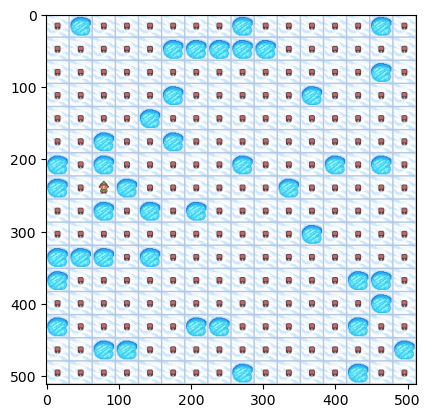

In [2]:
import matplotlib.pyplot as plt
from mango.environments import frozen_lake

init_kwargs = dict(
    map_name="RANDOM",
    size=16,
    p=0.8,
    random_start=True,
    #mirror=True,
    hide_goal=True,
)
env = frozen_lake.CustomFrozenLakeEnv(**init_kwargs) #type: ignore
env = frozen_lake.ReInitOnReset(env, **init_kwargs)
env = frozen_lake.TensorObservation(env, one_hot=True)
#env = frozen_lake.CoordinateObservation(env, one_hot=True)

obs, _ = env.reset()
print(f"{obs.shape=}, {obs.dtype=}")
plt.imshow(env.render()) #type: ignore
plt.show()

In [3]:
import torch
from mango.mango import Mango
from mango.abstractions.actions import GridMovement, GridMovementOneHot

n_layers = 2
net_params = dict(
    hidden_channels=[16, 16],
    hidden_features=[128, 64],
    activation_out=torch.nn.Tanh(),
    device=torch.device("cuda") if torch.cuda.is_available() else None,
)
mango = Mango(
    environment=env,
    abstract_actions=[
        GridMovementOneHot(cell_shape=(2**i, 2**i)) for i in range(1, n_layers + 1)
    ],
    policy_params=dict(lr=1e-3, net_params=net_params),
    verbose=False,
)
print(mango)

Mango(
  (1): MangoEnv(
    (environment): <TensorObservation<ReInitOnReset<CustomFrozenLakeEnv instance>>>
  )
  (2): MangoLayer(
    (abs_actions): GridMovementOneHot(cell_shape=(2, 2), action_space=Discrete(4), channel=0)
    (policy): DQnetPolicyMapper(comand_space=Discrete(4), action_space=Discrete(4))
  )
  (3): MangoLayer(
    (abs_actions): GridMovementOneHot(cell_shape=(4, 4), action_space=Discrete(4), channel=0)
    (policy): DQnetPolicyMapper(comand_space=Discrete(4), action_space=Discrete(4))
  )
)


In [4]:
from tqdm.notebook import tqdm
import numpy as np

N = 100
for randomness in (pbar := tqdm(np.linspace(1.0, 0.0, N)**2)):
    pbar.set_description(f"randomness: {randomness:.3f}")
    for layer in [1, 2]:
        mango.set_randomness(randomness, layer=layer)
    mango.explore(episode_length=1)
    mango.train()    

  0%|          | 0/100 [00:00<?, ?it/s]

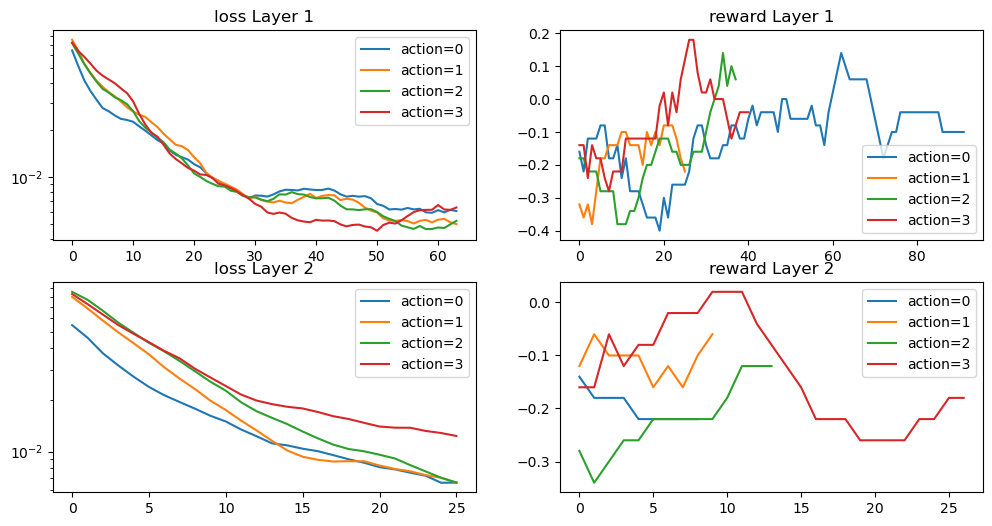

In [ ]:
from mango.utils import smooth

plt.figure(figsize=(12, 6))
for layer_idx, layer in enumerate(mango.abstract_layers, start=1):
    for action in range(layer.action_space.n):
        plt.subplot(2, len(mango.abstract_layers), 2*(layer_idx-1)+1)
        plt.title(f"loss Layer {layer_idx}")
        plt.semilogy(smooth(layer.train_loss_log[action]), label=f"{action=}")
        plt.legend()
    
        plt.subplot(2, len(mango.abstract_layers), 2*(layer_idx-1)+2)
        plt.title(f"reward Layer {layer_idx}")
        plt.plot(smooth(layer.intrinsic_reward_log[action]), label=f"{action=}")
        plt.legend()

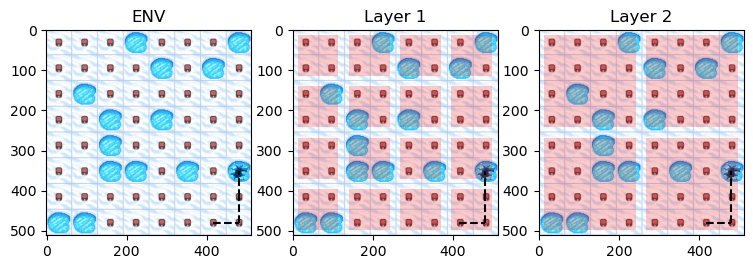

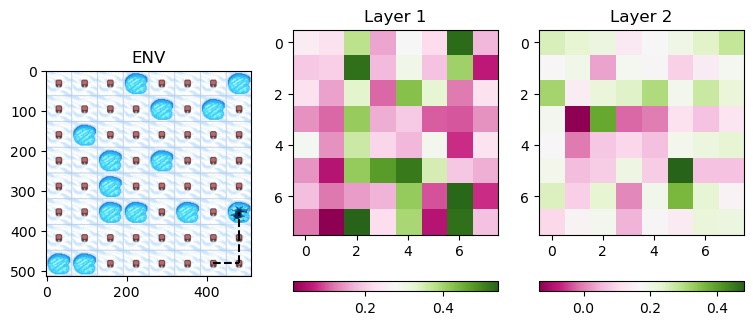

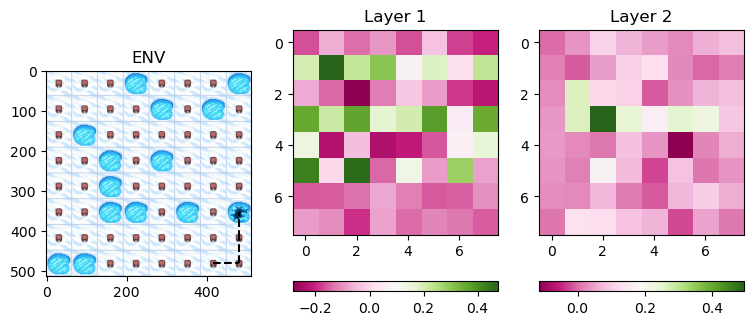

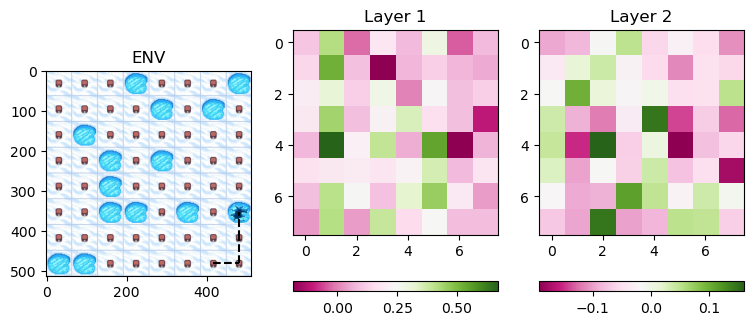

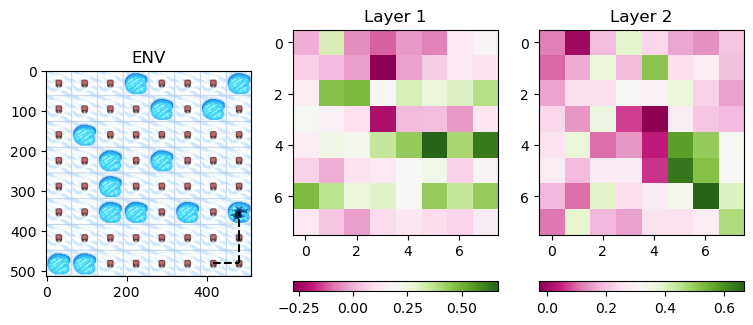

In [ ]:
from mango.utils import plot_grid, plot_trajectory, plot_qval_heatmap, obs2int, ActType


LEFT, DOWN, RIGHT, UP = ActType(0), ActType(1), ActType(2), ActType(3)
env_shape = (env.unwrapped.ncol, env.unwrapped.nrow)  # type: ignore
# spyral trajectory
planned_trajectory = [UP, RIGHT, DOWN, DOWN, LEFT, LEFT, UP, UP, UP]

obs, info = mango.reset()
trajetory = [obs]
for action in planned_trajectory:
    end_state, reward, trunc, term, info = mango.execute_option(
        layer=n_layers, action=action
    )
    trajetory.extend(info["mango:trajectory"])
int_trajectory = [obs2int(obs, env_shape, onehot=True) for obs in trajetory]


plt.figure(figsize=((1 + n_layers) * 3, 3))
plt.subplot(1, n_layers + 1, 1)
plt.title("ENV")
plt.imshow(env.render())  # type: ignore
plot_trajectory(int_trajectory, env_shape)
for i, layer in enumerate(mango.abstract_layers, start=1):
    plt.subplot(1, n_layers + 1, i + 1)
    plt.title(f"Layer {i}")
    plt.imshow(env.render())  # type: ignore
    plot_trajectory(int_trajectory, env_shape)
    plot_grid(env_shape, layer.abstract_actions.cell_shape)  # type: ignore
plt.show()

for action in [LEFT, DOWN, RIGHT, UP]:
    plt.figure(figsize=(3 * n_layers + 3, 4))
    plt.subplot(1, n_layers + 1, 1)
    plt.title("ENV")
    plt.imshow(env.render())  # type: ignore
    plot_trajectory(int_trajectory, env_shape)
    for i, layer in enumerate(mango.abstract_layers, start=1):
        plt.subplot(1, n_layers + 1, i + 1)
        plt.title(f"Layer {i}")
        plt.imshow(env.render())  # type: ignore
        policy = layer.policy.policies[action]
        plot_qval_heatmap(policy, env)
    plt.show()